In [2]:
# Lê Hoài Linh
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil


In [7]:
# Constants
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2296%2F3883%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG'
KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'

# Clean up any previous mounts and directories
!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# Create symbolic links
try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

# Download and extract data
for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)

    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            print()  # Newline after progress bar

            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)

            print(f'Downloaded and uncompressed: {directory}')

    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

Failed to load (likely expired) https://storage.googleapis.com/kaggle-data-sets/2296/3883/bundle/archive.zip?X-Goog-Algorithm=GOOG to path /kaggle/input/
Data source import complete.


In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import subprocess
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import os
print(os.listdir("../input"))

[]


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import pandas as pd
# Đọc dữ liệu từ tệp CSV vào DataFrame
sales = pd.read_csv("/content/drive/MyDrive/sales data-set.csv")
features = pd.read_csv("/content/drive/MyDrive/Features data set.csv")
stores = pd.read_csv("/content/drive/MyDrive/stores data-set.csv")
print("Sales Total Col.",len(sales.columns),"\nShape:",sales.shape,"\nColumns:",sales.columns.tolist(),"\n=============")
print("Features Total Col.",len(features.columns),"\nShape:", features.shape, "\nColumns:",features.columns.tolist(),"\n=============")
print("Stores Total Col.",len(stores.columns),"\nShape:",stores.shape, "\nColumns:",stores.columns.tolist())

Sales Total Col. 5 
Shape: (421570, 5) 
Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'] 
Features Total Col. 12 
Shape: (8190, 12) 
Columns: ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday'] 
Stores Total Col. 3 
Shape: (45, 3) 
Columns: ['Store', 'Type', 'Size']


In [35]:
def insight(df):
  print("--------------------")
  print(df.head())
  insight(sales)
  insight(features)
  insight(stores)

In [36]:
final = sales.merge(features,how="left", on=['Store', 'Date', 'IsHoliday'])
final = final.merge(stores, how= "left", on=['Store'])
final.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,05/02/2010,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,12/02/2010,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,05/03/2010,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [37]:
print("Final Dataset Col:",len(final.columns),"\nShape: ",final.shape,"\nColumns",final.columns.tolist())
info = pd.DataFrame(final.dtypes).T.rename(index = {0:'Column Type'})
info = info.append(pd.DataFrame(final.isnull().sum()).T.rename(index = {0:'null values (nb)'}))
info = info.append(pd.DataFrame(final.isnull().sum()/final.shape[0]*100).T.rename(index = {0:'null values{%}'}))
info

Final Dataset Col: 16 
Shape:  (421570, 16) 
Columns ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']


<ipython-input-37-0794e8d303a9>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(pd.DataFrame(final.isnull().sum()).T.rename(index = {0:'null values (nb)'}))
<ipython-input-37-0794e8d303a9>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(pd.DataFrame(final.isnull().sum()/final.shape[0]*100).T.rename(index = {0:'null values{%}'}))


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Column Type,int64,int64,object,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64
null values (nb),0,0,0,0,0,0,0,270889,310322,284479,286603,270138,0,0,0,0
null values{%},0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.257181,73.611025,67.480845,67.984676,64.079038,0.0,0.0,0.0,0.0


In [38]:
final.fillna(-9999, inplace=True)
info = pd.DataFrame(final.dtypes).T.rename(index = {0:'Column Type'})
info = info.append(pd.DataFrame(final.isnull().sum()).T.rename(index = {0:'null values (nb)'}))
info = info.append(pd.DataFrame(final.isnull().sum()/final.shape[0]*100).T.rename(index = {0:'null values{%}'}))
info

<ipython-input-38-188a51851ab3>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(pd.DataFrame(final.isnull().sum()).T.rename(index = {0:'null values (nb)'}))
<ipython-input-38-188a51851ab3>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(pd.DataFrame(final.isnull().sum()/final.shape[0]*100).T.rename(index = {0:'null values{%}'}))


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Column Type,int64,int64,object,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values{%},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
print("Duplicate Values : ",final.duplicated().sum())


Duplicate Values :  0


In [40]:

final = final.applymap(lambda x: 1 if x == True else x)
final = final.applymap(lambda x: 0 if x == False else x)

final.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,05/02/2010,24924.50,0,42.31,2.572,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,211.096358,8.106,A,151315
1,1,1,12/02/2010,46039.49,1,38.51,2.548,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,0,39.93,2.514,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,0,46.63,2.561,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,211.319643,8.106,A,151315
4,1,1,05/03/2010,21827.90,0,46.50,2.625,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,211.350143,8.106,A,151315


           Date  Weekly_Sales
112  24/12/2010   80931415.60
107  23/12/2011   76998241.31
117  25/11/2011   66593605.26
122  26/11/2010   65821003.24
79   17/12/2010   61820799.85
74   16/12/2011   60085695.94
46   10/12/2010   55666770.39
41   09/12/2011   55561147.70
25   06/04/2012   53502315.87
27   06/07/2012   51253021.88


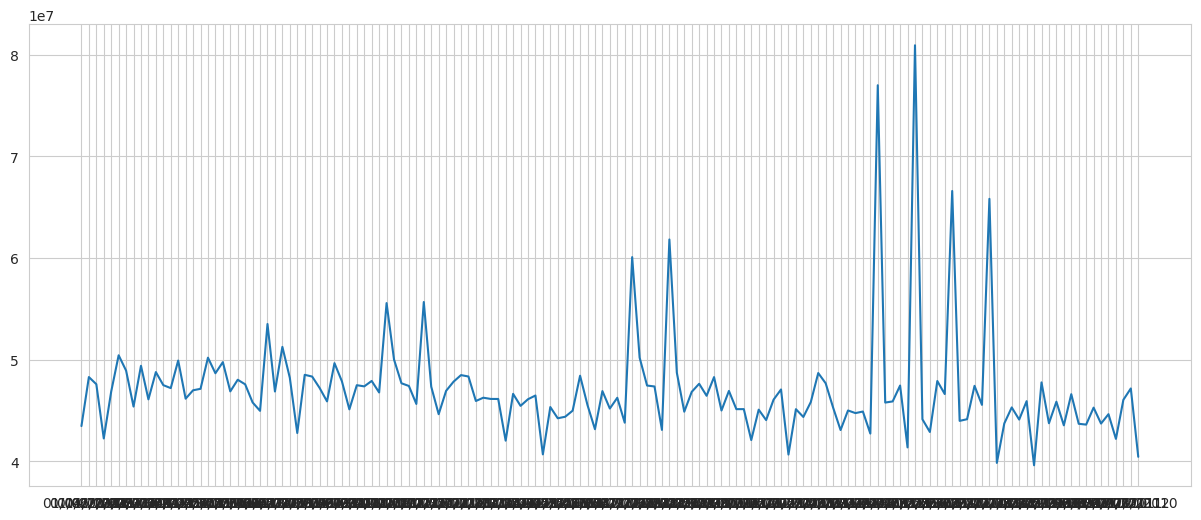

In [41]:
df_average_sales_week = final.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
df_average_sales = df_average_sales_week.sort_values('Weekly_Sales', ascending=False)
print(df_average_sales[:10])
#Seasonality vs Trend Analysis
plt.figure(figsize=(15,6))
plt.plot(df_average_sales_week.Date, df_average_sales_week.Weekly_Sales)
plt.show()

   IsHoliday  Weekly_Sales
0          0  6.231919e+09
1          1  5.052996e+08


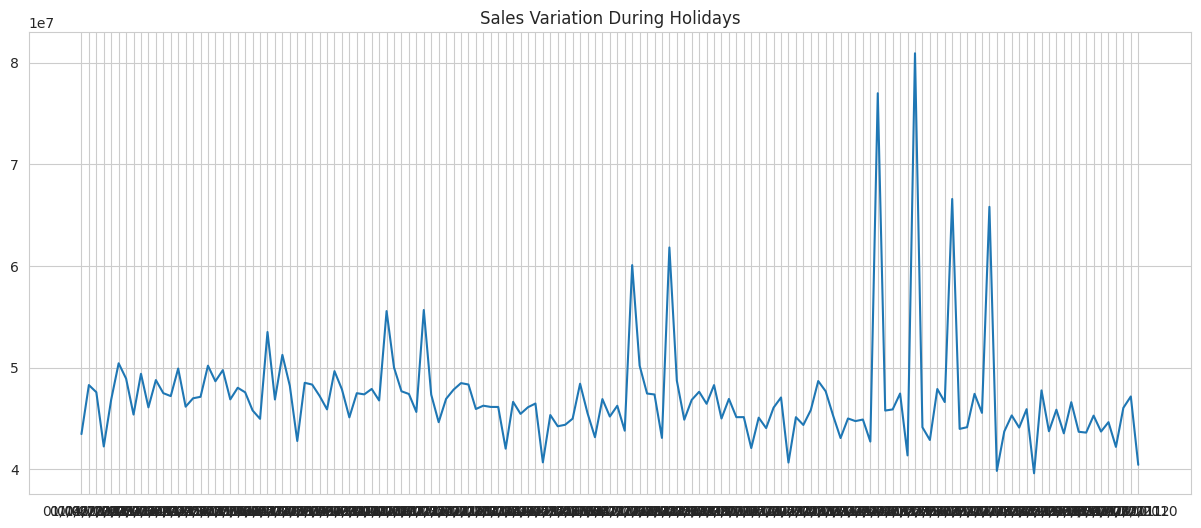

In [44]:
#Sales variation during Holidays(Store/Dept)
holiday = final[['Date', 'IsHoliday', 'Weekly_Sales']].copy()
holiday = holiday.groupby(by=['Date','IsHoliday'], as_index=False)['Weekly_Sales'].sum()
holiday_group = holiday.groupby(by=['IsHoliday'], as_index=False)['Weekly_Sales'].sum()
print( holiday_group)
#print( holiday[:5])
def holiday_sales(df):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(15,6))
  labels = ['Date', 'IsHoliday_x', 'Weekly_Sales']
  plt.title('Sales Variation During Holidays')
  plt.plot(df.Date, df.Weekly_Sales)
  plt.show()
holiday_sales(holiday)

In [45]:
final['Return'] = (final['Weekly_Sales'] < 0).astype('int')
final_group = final.groupby(['Return'], as_index = False)['Weekly_Sales'].sum()
final_group

,Return,Weekly_Sales
0,0,6.737307e+09
1,1,-8.816156e+04


In [46]:
#Making Avg MarkDown
final['AvgMarkDown'] = final['MarkDown1'] + final['MarkDown2'] + final['MarkDown3'] + final['MarkDown4'] + final['MarkDown5']
final['AvgMarkDown'] = final['AvgMarkDown'] / 5
final.AvgMarkDown[378:385]

378     5134.336
379     2559.290
380    11375.348
381     5931.116
382     4573.182
383     1932.570
384     1232.974
Name: AvgMarkDown, dtype: float64

In [47]:
#Creating Weekly sales in a 4 range
final['cum_sum'] = final.Weekly_Sales.cumsum()
final['cum_perc'] = 100*final.cum_sum/final.Weekly_Sales.sum()
final['rangeA'] = 0
final['rangeA'][final['cum_perc'] <= 25] = 1
final['rangeB'] = 0
final['rangeB'][(final['cum_perc'] > 25) & (final['cum_perc'] <= 50)] = 1
final['rangeC'] = 0
final['rangeC'][(final['cum_perc'] > 50) & (final['cum_perc'] <= 75)] = 1
final['rangeD'] = 0
final['rangeD'][final['cum_perc'] > 75] = 1
final = final.drop(['cum_perc', 'cum_sum'], 1)
final.head(100)

<ipython-input-47-cea58ca521f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['rangeA'][final['cum_perc'] <= 25] = 1
<ipython-input-47-cea58ca521f9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['rangeB'][(final['cum_perc'] > 25) & (final['cum_perc'] <= 50)] = 1
<ipython-input-47-cea58ca521f9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['rangeC'][(final['cum_perc'] > 50) & (final['cum_perc'] <= 75)] = 1
<ip

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,CPI,Unemployment,Type,Size,Return,AvgMarkDown,rangeA,rangeB,rangeC,rangeD
0,1,1,05/02/2010,24924.50,0,42.31,2.572,-9999.00,-9999.00,-9999.00,...,211.096358,8.106,A,151315,0,-9999.000,1,0,0,0
1,1,1,12/02/2010,46039.49,1,38.51,2.548,-9999.00,-9999.00,-9999.00,...,211.242170,8.106,A,151315,0,-9999.000,1,0,0,0
2,1,1,19/02/2010,41595.55,0,39.93,2.514,-9999.00,-9999.00,-9999.00,...,211.289143,8.106,A,151315,0,-9999.000,1,0,0,0
3,1,1,26/02/2010,19403.54,0,46.63,2.561,-9999.00,-9999.00,-9999.00,...,211.319643,8.106,A,151315,0,-9999.000,1,0,0,0
4,1,1,05/03/2010,21827.90,0,46.50,2.625,-9999.00,-9999.00,-9999.00,...,211.350143,8.106,A,151315,0,-9999.000,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,1,02/12/2011,25293.49,0,48.91,3.172,5629.51,68.00,1398.11,...,218.714733,7.866,A,151315,0,5931.116,1,0,0,0
96,1,1,09/12/2011,33305.92,0,43.93,3.158,4640.65,19.00,105.02,...,218.961846,7.866,A,151315,0,4573.182,1,0,0,0
97,1,1,16/12/2011,45773.03,0,51.63,3.159,5011.32,67.00,347.37,...,219.179453,7.866,A,151315,0,1932.570,1,0,0,0
98,1,1,23/12/2011,46788.75,0,47.96,3.112,2725.36,40.48,634.70,...,219.357722,7.866,A,151315,0,1232.974,1,0,0,0


In [48]:
#Aggregate the Top performing stores interms of sales
top_stores = final.groupby(by=['Type'], as_index=False)['Weekly_Sales'].sum()
top_stores

,Type,Weekly_Sales
0,A,4.331015e+09
1,B,2.000701e+09
2,C,4.055035e+08


In [49]:
clm = final[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size',
'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'AvgMarkDown', 'rangeA',
'rangeB', 'rangeC', 'rangeD', 'Return']].copy()

clm.corr()

<ipython-input-49-50e76a3ba5fc>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  clm.corr()


,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,AvgMarkDown,rangeA,rangeB,rangeC,rangeD,Return
Weekly_Sales,1.000000,-0.002312,-0.000120,-0.020921,-0.025864,0.243828,0.033450,0.030098,0.041885,0.040800,0.030893,0.041876,0.030899,0.042184,0.011996,-0.078035,-0.039076
Temperature,-0.002312,1.000000,0.143859,0.182112,0.096730,-0.058313,-0.023022,-0.167249,-0.061655,-0.057157,-0.015049,-0.074268,0.146173,-0.122620,-0.093847,0.064937,-0.000408
Fuel_Price,-0.000120,0.143859,1.000000,-0.164210,-0.033853,0.003361,0.427581,0.211915,0.288307,0.380233,0.411167,0.413472,-0.123035,0.055708,0.102799,-0.033664,0.005459
CPI,-0.020921,0.182112,-0.164210,1.000000,-0.299953,-0.003314,0.040587,0.030209,0.035079,0.037474,0.077950,0.052692,0.358054,-0.192377,-0.161769,-0.002916,-0.004713
Unemployment,-0.025864,0.096730,-0.033853,-0.299953,1.000000,-0.068238,-0.176959,-0.129358,-0.137208,-0.183051,-0.201196,-0.197379,-0.266233,0.053173,0.084719,0.117235,0.002055
Size,0.243828,-0.058313,0.003361,-0.003314,-0.068238,1.000000,0.107314,0.109573,0.058181,0.148591,0.079007,0.119014,-0.025250,0.143315,0.102413,-0.202991,-0.006422
MarkDown1,0.033450,-0.023022,0.427581,0.040587,-0.176959,0.107314,1.000000,0.577081,0.538528,0.935263,0.800217,0.926607,-0.003652,0.032053,0.024799,-0.049005,0.000758
MarkDown2,0.030098,-0.167249,0.211915,0.030209,-0.129358,0.109573,0.577081,1.000000,0.411877,0.572866,0.568744,0.741032,0.011335,0.038232,0.019497,-0.063457,0.002262
MarkDown3,0.041885,-0.061655,0.288307,0.035079,-0.137208,0.058181,0.538528,0.411877,1.000000,0.529636,0.580903,0.724293,0.008443,0.018178,0.007212,-0.031056,-0.001268
MarkDown4,0.040800,-0.057157,0.380233,0.037474,-0.183051,0.148591,0.935263,0.572866,0.529636,1.000000,0.762356,0.910057,0.020905,0.047722,0.033903,-0.094365,0.000402


<ipython-input-52-9d435e3d68d6>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 50)
<ipython-input-52-9d435e3d68d6>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
<ipython-input-52-9d435e3d68d6>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels, fontsize=6)
<ipython-input-52-9d435e3d68d6>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(labels, fontsize=6)


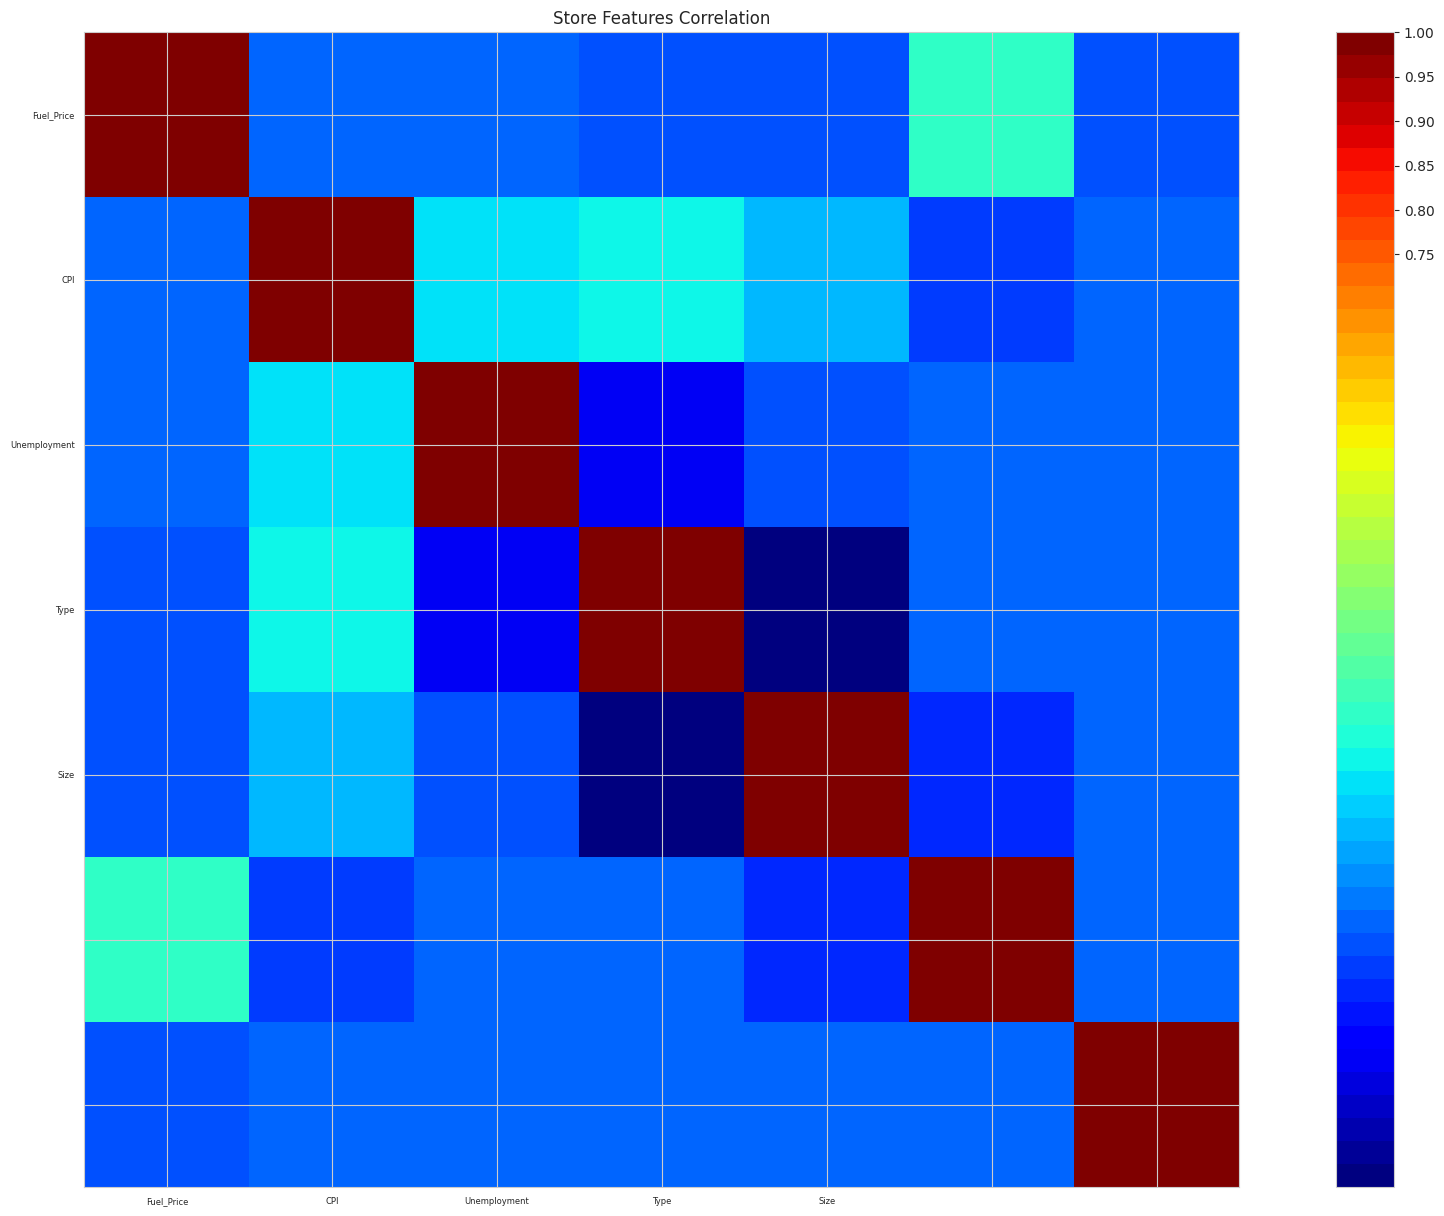

In [52]:
clm = final[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size','Return']].copy()
def correlation_matrix(df):
  from matplotlib import pyplot as plt
  from matplotlib import cm as cm
  fig = plt.figure(figsize = (25,15))
  ax1 = fig.add_subplot(111)
  cmap = cm.get_cmap('jet', 50)
  cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
  ax1.grid(True)
  plt.title('Store Features Correlation')
  labels=['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size']
  ax1.set_xticklabels(labels, fontsize=6)
  ax1.set_yticklabels(labels, fontsize=6)
  #Add colorbar to make sure to specify a tick location to match desired tick labels
  fig.colorbar(cax, ticks=[.75, .8, .85, .90, .95, 1])
  plt.show()
correlation_matrix(clm)